# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [3]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

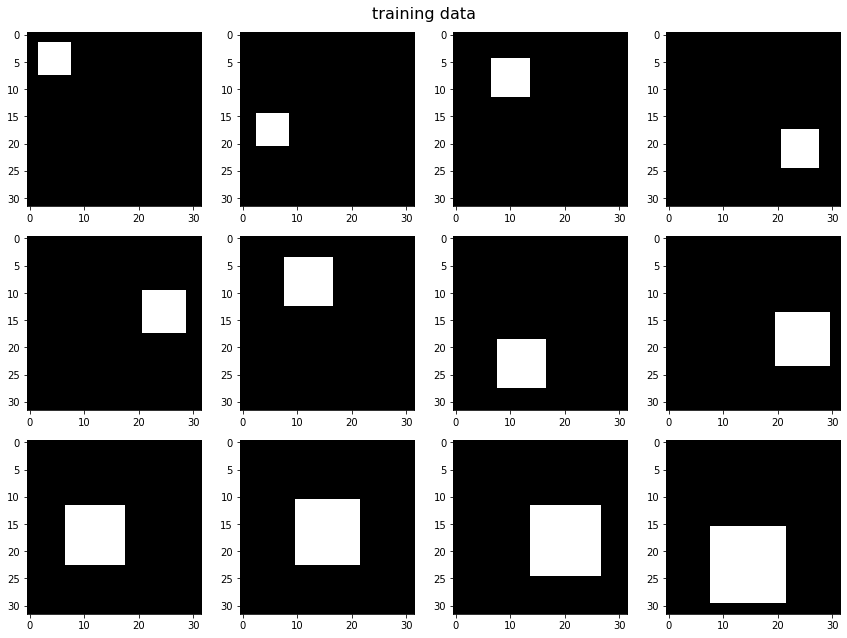

In [5]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [8]:
print(device)

cuda


In [9]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders 

In [10]:
size_minibatch  = 32
dim_latent      = 64 # input latent vector fixed dimension 

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [11]:
class Discriminator(nn.Module): 
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.LeakyReLU(0.2),
#             nn.Linear(64, 32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 16),
#             nn.LeakyReLU(0.2),
#             nn.Linear(16, 8),
#             nn.LeakyReLU(0.2),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        out = self.conv(x)
        out = nn.Flatten()(out)
        out = self.fc(out)
        
        return out


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=dim_latent, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            
            nn.Sigmoid()
        )
    
    def forward(self, x):

        out = self.conv(x)
        
        return out

## build network

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 1.)
    elif classname.find("BatchNorm") != -1:
        nn.init.constant_(m.weight, 1.)
        nn.init.constant_(m.bias, 1.)
    elif classname.find("Linear") != -1:
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 1.)

In [14]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

## compute the prediction

In [15]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [16]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [17]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [18]:
def train(generator, discriminator, dataloader):
    
    loss_generator_epoch = []
    loss_discriminator_epoch = []
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        
        optimizer_generator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_fake = compute_prediction(discriminator, fake)
        label_fake = torch.ones_like(prediction_fake)
        loss_label = nn.BCEWithLogitsLoss()(prediction_fake, label_fake)
        loss_generator = loss_label
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        optimizer_discriminator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_real = compute_prediction(discriminator, real)
        prediction_fake = compute_prediction(discriminator, fake)
        loss_real = nn.BCEWithLogitsLoss()(prediction_real, torch.ones_like(prediction_real, device=device))
        loss_fake = nn.BCEWithLogitsLoss()(prediction_fake, torch.zeros_like(prediction_fake, device=device))
        loss_discriminator = (loss_real + loss_fake) / 2.
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        loss_generator_epoch.append(loss_generator.item())
        loss_discriminator_epoch.append(loss_discriminator.item())
    
    return np.mean(loss_generator_epoch), np.mean(loss_discriminator_epoch)

## test

In [19]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [20]:
number_epoch    = 1000
accuracy_epoch  = np.zeros(number_epoch)
loss_generator = np.zeros(number_epoch)
loss_discriminator = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in range(number_epoch):
    loss_generator_epoch, loss_discriminator_epoch = train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy
    
    loss_generator[i] = loss_generator_epoch
    loss_discriminator[i] = loss_discriminator_epoch
    print(f'epoch {i}, loss_generator = {loss_generator_epoch}, loss_discriminator={loss_discriminator_epoch}, accuracy={accuracy}')
    
    # if accuracy>97 stop
    if accuracy>97:
        accuracy_epoch = accuracy_epoch[:i+1]
        break

epoch 0, loss_generator = 0.814472322386724, loss_discriminator=0.7667386999836674, accuracy=85.56204986572266
epoch 1, loss_generator = 0.701113517637606, loss_discriminator=0.6974989665879143, accuracy=86.67979431152344
epoch 2, loss_generator = 0.7101906295175906, loss_discriminator=0.7027507592130591, accuracy=88.6302490234375
epoch 3, loss_generator = 0.7364996938793748, loss_discriminator=0.6938639314086349, accuracy=83.3341064453125
epoch 4, loss_generator = 0.889074479871326, loss_discriminator=0.664303242277216, accuracy=83.06291198730469
epoch 5, loss_generator = 1.1001035770884267, loss_discriminator=0.6149265412931089, accuracy=74.93197631835938
epoch 6, loss_generator = 1.163874872967049, loss_discriminator=0.5769948347851083, accuracy=80.956787109375
epoch 7, loss_generator = 1.1273606496828574, loss_discriminator=0.5647585698851832, accuracy=77.10784912109375
epoch 8, loss_generator = 1.2064856220174718, loss_discriminator=0.5379378175293957, accuracy=78.06034851074219
e

epoch 73, loss_generator = 4.675500431767216, loss_discriminator=0.20187559431349789, accuracy=92.41947174072266
epoch 74, loss_generator = 4.672733308650829, loss_discriminator=0.23582654656083496, accuracy=92.24749755859375
epoch 75, loss_generator = 4.374022044958892, loss_discriminator=0.26813614666461943, accuracy=91.54234313964844
epoch 76, loss_generator = 4.631091837529783, loss_discriminator=0.2454431015584204, accuracy=92.3125
epoch 77, loss_generator = 4.2927023101736, loss_discriminator=0.317950893441836, accuracy=92.99960327148438
epoch 78, loss_generator = 4.0452820053807015, loss_discriminator=0.32753366386448896, accuracy=92.31820678710938
epoch 79, loss_generator = 4.6592957072787815, loss_discriminator=0.3111189565172902, accuracy=92.62467956542969
epoch 80, loss_generator = 4.630603435745946, loss_discriminator=0.30288396135524465, accuracy=93.29022216796875
epoch 81, loss_generator = 4.8747747580210365, loss_discriminator=0.2623639147038813, accuracy=92.895751953125

epoch 146, loss_generator = 6.743567724581118, loss_discriminator=0.2377501794585475, accuracy=95.57379150390625
epoch 147, loss_generator = 7.042205512082135, loss_discriminator=0.2042471671545947, accuracy=94.4318618774414
epoch 148, loss_generator = 6.420975275392886, loss_discriminator=0.22820220208830302, accuracy=93.08052062988281
epoch 149, loss_generator = 6.5609172008655685, loss_discriminator=0.22166126856097468, accuracy=94.54338836669922
epoch 150, loss_generator = 6.707070308261447, loss_discriminator=0.24671511716312833, accuracy=93.50298309326172
epoch 151, loss_generator = 6.7390508457466405, loss_discriminator=0.24534815494660978, accuracy=93.63294219970703
epoch 152, loss_generator = 6.6802564921202485, loss_discriminator=0.24413852559195626, accuracy=94.2320556640625
epoch 153, loss_generator = 6.41505310093915, loss_discriminator=0.25199163059393564, accuracy=93.73854064941406
epoch 154, loss_generator = 6.8787972414935075, loss_discriminator=0.23879027167956035, ac

epoch 219, loss_generator = 7.048144442946823, loss_discriminator=0.14878281296955215, accuracy=91.73857879638672
epoch 220, loss_generator = 7.0863489115679705, loss_discriminator=0.16045031588938502, accuracy=91.46617126464844
epoch 221, loss_generator = 6.5701484874442775, loss_discriminator=0.17035361070323873, accuracy=69.65313720703125
epoch 222, loss_generator = 6.929634931352403, loss_discriminator=0.15448496548665894, accuracy=64.93849182128906
epoch 223, loss_generator = 6.9369962586296925, loss_discriminator=0.15019901874992583, accuracy=50.18601989746094
epoch 224, loss_generator = 6.160572200351291, loss_discriminator=0.16919080797168945, accuracy=58.94017791748047
epoch 225, loss_generator = 6.755799595514933, loss_discriminator=0.16539691377569127, accuracy=75.2309799194336
epoch 226, loss_generator = 7.192727371498391, loss_discriminator=0.15507393272386658, accuracy=66.45307922363281
epoch 227, loss_generator = 7.282311047448053, loss_discriminator=0.1588365834068369, 

epoch 292, loss_generator = 8.978465839668557, loss_discriminator=0.14820937561216177, accuracy=93.41437530517578
epoch 293, loss_generator = 9.358383618460762, loss_discriminator=0.15628491750469914, accuracy=92.46980285644531
epoch 294, loss_generator = 7.929611956631696, loss_discriminator=0.17867613153325188, accuracy=95.12992858886719
epoch 295, loss_generator = 9.19967207732024, loss_discriminator=0.15542922072388507, accuracy=93.99972534179688
epoch 296, loss_generator = 9.087457709842258, loss_discriminator=0.15541594271306639, accuracy=80.13921356201172
epoch 297, loss_generator = 10.82458976816248, loss_discriminator=0.1310999002997522, accuracy=54.59040832519531
epoch 298, loss_generator = 10.589052546465838, loss_discriminator=0.12162910735717526, accuracy=74.05311584472656
epoch 299, loss_generator = 10.146356296539306, loss_discriminator=0.12383982362570586, accuracy=85.86341857910156
epoch 300, loss_generator = 10.138783705676044, loss_discriminator=0.10846407151332609, 

epoch 365, loss_generator = 9.767763738278989, loss_discriminator=0.08070050506956047, accuracy=90.1957778930664
epoch 366, loss_generator = 11.063694689008924, loss_discriminator=0.07352780398602286, accuracy=93.65068054199219
epoch 367, loss_generator = 9.055534825501619, loss_discriminator=0.08070847016448776, accuracy=93.96336364746094
epoch 368, loss_generator = 9.240705864517777, loss_discriminator=0.08322153839248198, accuracy=94.82147216796875
epoch 369, loss_generator = 8.68415961795383, loss_discriminator=0.09607043510854796, accuracy=95.21580505371094
epoch 370, loss_generator = 8.72154471785934, loss_discriminator=0.09640413088103135, accuracy=90.732177734375
epoch 371, loss_generator = 10.039064350834598, loss_discriminator=0.07917902607608725, accuracy=94.65101623535156
epoch 372, loss_generator = 9.407221027656838, loss_discriminator=0.08400566849719596, accuracy=94.9950942993164
epoch 373, loss_generator = 8.890281200408936, loss_discriminator=0.07600207053193891, accur

epoch 438, loss_generator = 9.30208995960377, loss_discriminator=0.10868718030828017, accuracy=88.33406066894531
epoch 439, loss_generator = 8.167641039247867, loss_discriminator=0.12049318185007131, accuracy=93.90167236328125
epoch 440, loss_generator = 8.797812122768827, loss_discriminator=0.12059345226045008, accuracy=94.76558685302734
epoch 441, loss_generator = 9.679817630626538, loss_discriminator=0.14019262633389898, accuracy=94.6182632446289
epoch 442, loss_generator = 9.014794925407127, loss_discriminator=0.14639428241385355, accuracy=95.63656616210938
epoch 443, loss_generator = 10.046305815378824, loss_discriminator=0.14286163912879096, accuracy=94.94783020019531
epoch 444, loss_generator = 9.095356255990488, loss_discriminator=0.1585432456323394, accuracy=95.1871337890625
epoch 445, loss_generator = 10.976585381119339, loss_discriminator=0.1347153542218385, accuracy=92.68020629882812
epoch 446, loss_generator = 9.39143352508545, loss_discriminator=0.13657849778731665, accur

epoch 510, loss_generator = 11.581555702068188, loss_discriminator=0.08746948934815547, accuracy=94.99003601074219
epoch 511, loss_generator = 11.154386654606572, loss_discriminator=0.09561251175624352, accuracy=96.87024688720703
epoch 512, loss_generator = 11.570872494026467, loss_discriminator=0.0942874719630237, accuracy=95.28645324707031
epoch 513, loss_generator = 10.235200892554388, loss_discriminator=0.09093982037846689, accuracy=94.85589599609375
epoch 514, loss_generator = 10.600609224813956, loss_discriminator=0.08474328110201491, accuracy=95.34131622314453
epoch 515, loss_generator = 11.14383470747206, loss_discriminator=0.0930094241268105, accuracy=96.08834075927734
epoch 516, loss_generator = 10.171866190875019, loss_discriminator=0.10505730381442441, accuracy=96.12146759033203
epoch 517, loss_generator = 12.25813018657543, loss_discriminator=0.07980874702334403, accuracy=94.49168395996094
epoch 518, loss_generator = 9.942544386121963, loss_discriminator=0.1008692271731517

epoch 582, loss_generator = 12.908173691784894, loss_discriminator=0.16094523110875378, accuracy=95.02164459228516
epoch 583, loss_generator = 12.48980324709857, loss_discriminator=0.15528052736211706, accuracy=79.65757751464844
epoch 584, loss_generator = 14.113891566241229, loss_discriminator=0.1413310378238007, accuracy=67.49818420410156
epoch 585, loss_generator = 13.99550495147705, loss_discriminator=0.1322389729321003, accuracy=89.31112670898438
epoch 586, loss_generator = 15.183638042873806, loss_discriminator=0.11232580749524965, accuracy=95.0408935546875
epoch 587, loss_generator = 13.337518628438314, loss_discriminator=0.121464485730286, accuracy=83.31907653808594
epoch 588, loss_generator = 13.636686780717637, loss_discriminator=0.11887091249227524, accuracy=74.44181060791016
epoch 589, loss_generator = 12.6487231431184, loss_discriminator=0.10779109056349154, accuracy=94.72286987304688
epoch 590, loss_generator = 15.023755882404469, loss_discriminator=0.10330780766628407, a

epoch 654, loss_generator = 9.159493933783637, loss_discriminator=0.049836119450628755, accuracy=94.57791137695312
epoch 655, loss_generator = 9.131525241004097, loss_discriminator=0.05634196183333794, accuracy=94.9825668334961
epoch 656, loss_generator = 7.624722454282972, loss_discriminator=0.06407521404325962, accuracy=95.16156005859375
epoch 657, loss_generator = 7.871964758413809, loss_discriminator=0.06413499788312173, accuracy=96.27721405029297
epoch 658, loss_generator = 7.9279554684956866, loss_discriminator=0.06661501869352328, accuracy=93.30516052246094
epoch 659, loss_generator = 7.867194779713949, loss_discriminator=0.07434183331206441, accuracy=85.36262512207031
epoch 660, loss_generator = 8.283381599850125, loss_discriminator=0.0803944197897282, accuracy=94.06887817382812
epoch 661, loss_generator = 9.575551244947645, loss_discriminator=0.08435174507537374, accuracy=94.96089172363281
epoch 662, loss_generator = 7.334503156167489, loss_discriminator=0.08459679994870115, a

---

# functions for presenting the results

---

In [21]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [22]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [23]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



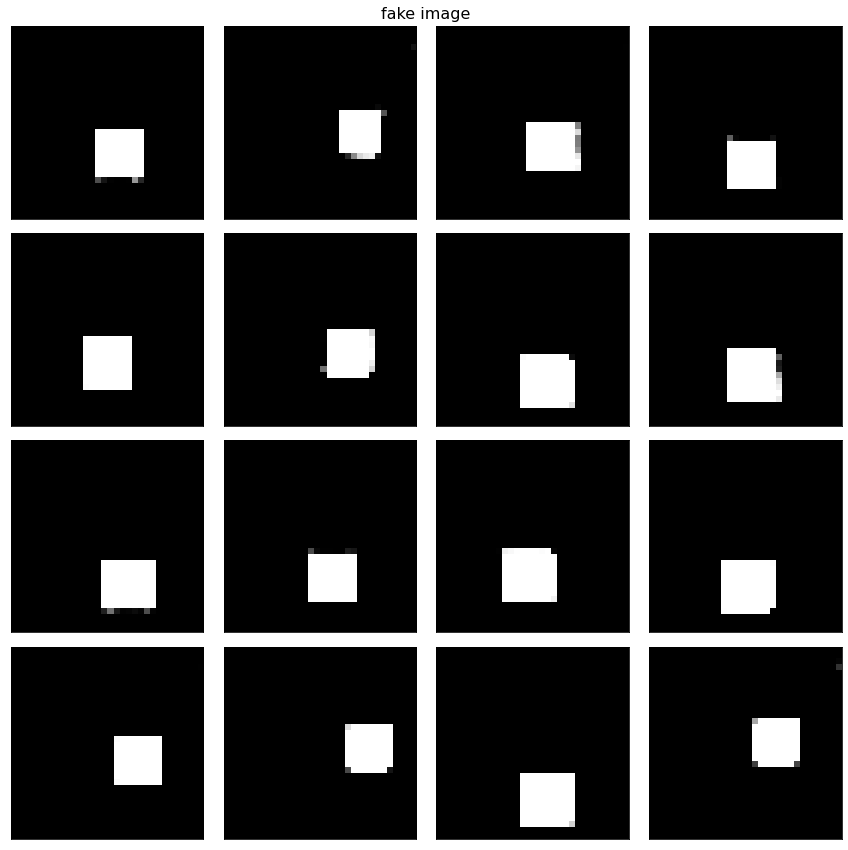

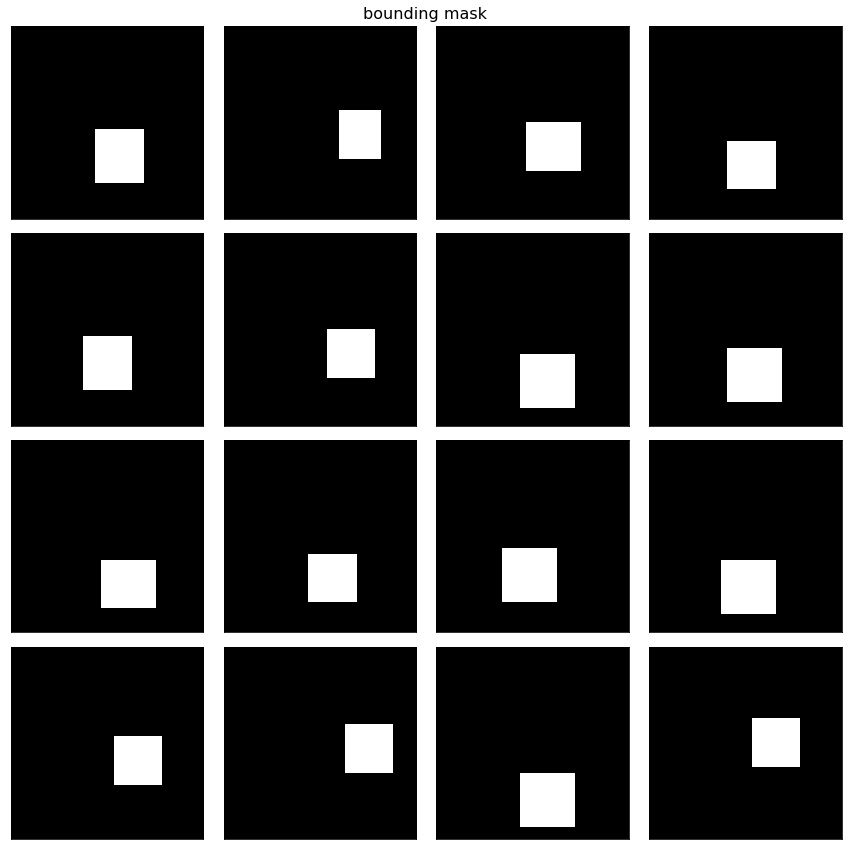


################################################################################
#
# RESULT # 02
#
################################################################################



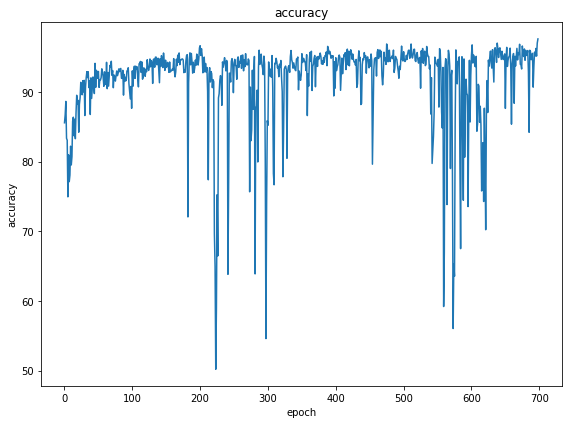


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 97.59718323


In [24]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)